In [1]:
options(stringsAsFactors=F)
options(max.print=1000)
suppressPackageStartupMessages(library(argparse))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggsci))
suppressPackageStartupMessages(library(ggrepel))
suppressPackageStartupMessages(library(gridExtra))
suppressPackageStartupMessages(library(RColorBrewer))
suppressPackageStartupMessages(library(circlize))
suppressPackageStartupMessages(library(ggpubr))
suppressPackageStartupMessages(library(corrplot))
suppressPackageStartupMessages(library(igraph))
suppressPackageStartupMessages(library(cowplot))
suppressPackageStartupMessages(library(ggsignif))
suppressPackageStartupMessages(library(ggpubr))
options(bitmapType = 'cairo', device = 'png')


setwd('/psycl/g/mpsziller/lucia/CAD_UKBB/eQTL_PROJECT')
fold_notebook <- '/psycl/g/mpsziller/lucia/castom_cad_scz/jupyter_notebook/'
tissues_name <- read.table('OUTPUT_GTEx/Tissue_CADgwas', h=F, stringsAsFactors = F)$V1
tissues_name <- tissues_name[!tissues_name %in% c('Artery_Tibial', 'Small_Intestine_Terminal_Ileum', 'Stomach', 'Thyroid')]
clust_res <- sprintf('OUTPUT_GTEx/predict_CAD/%s/200kb/CAD_GWAS_bin5e-2/UKBB/devgeno0.01_testdevgeno0/CAD_HARD_clustering/update_corrPCs/tscore_corrPCs_zscaled_clusterCases_PGmethod_HKmetric.RData', tissues_name)

outFold <- sprintf('%sCAD_clustering/', fold_notebook)
type_data <- 'tscore'
type_input <- 'zscaled'
type_cluster <- 'Cases'
pheno_name <- 'CAD'
color_tissues_file <- sprintf('%scolor_tissues.txt', fold_notebook)


In [9]:
NMI_mat <- matrix(0, ncol = length(tissues_name), nrow = length(tissues_name))
df_cluster <- data.frame(tissue = tissues_name, n_cluster = NA, modularity = NA, coverage_and_conductance = NA)
df_div <- data.frame(tissue = c(), n_samples = c(), gr = c() )
tot_cl <- list()
for(i in 1:length(tissues_name)){
    print(i)
    tot_cl[[i]] <- get(load(clust_res[i]))
    tmp <- tot_cl[[i]]
    cl1 <- tmp$cl_best$gr
    df_cluster$n_cluster[i] <- tmp$info_tune$n_clusters
    df_cluster$modularity[i] <- tmp$info_tune$modularity
    df_cluster$coverage_and_conductance[i] <- tmp$info_tune$coverage_and_conductance
    df_div <- rbind(df_div, data.frame(tissue = rep(tissues_name[i], tmp$info_tune$n_clusters), n_samples = sapply(sort(unique(cl1)), function(x) sum(cl1 == x)), gr = sort(unique(cl1))))
}
df_div$gr <- paste0('gr',df_div$gr)

for(i in 1:length(tissues_name)){
  cl1 <- tot_cl[[i]]$cl_best$gr
  if(i<length(tissues_name)){
    for(j in (i+1):length(tissues_name)){
        cl2 <- tot_cl[[j]]$cl_best$gr
        NMI_mat[i, j] <- compare(cl1, cl2, method = 'nmi')
    }
  }
}

rownames(NMI_mat) <- colnames(NMI_mat) <- tissues_name                                                                                                   
color_tissues <- read.table(color_tissues_file, h=T, stringsAsFactors = F)

# correlation
NMI_mat <- NMI_mat + t(NMI_mat)
diag(NMI_mat) <- NA


[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11


png 
  2

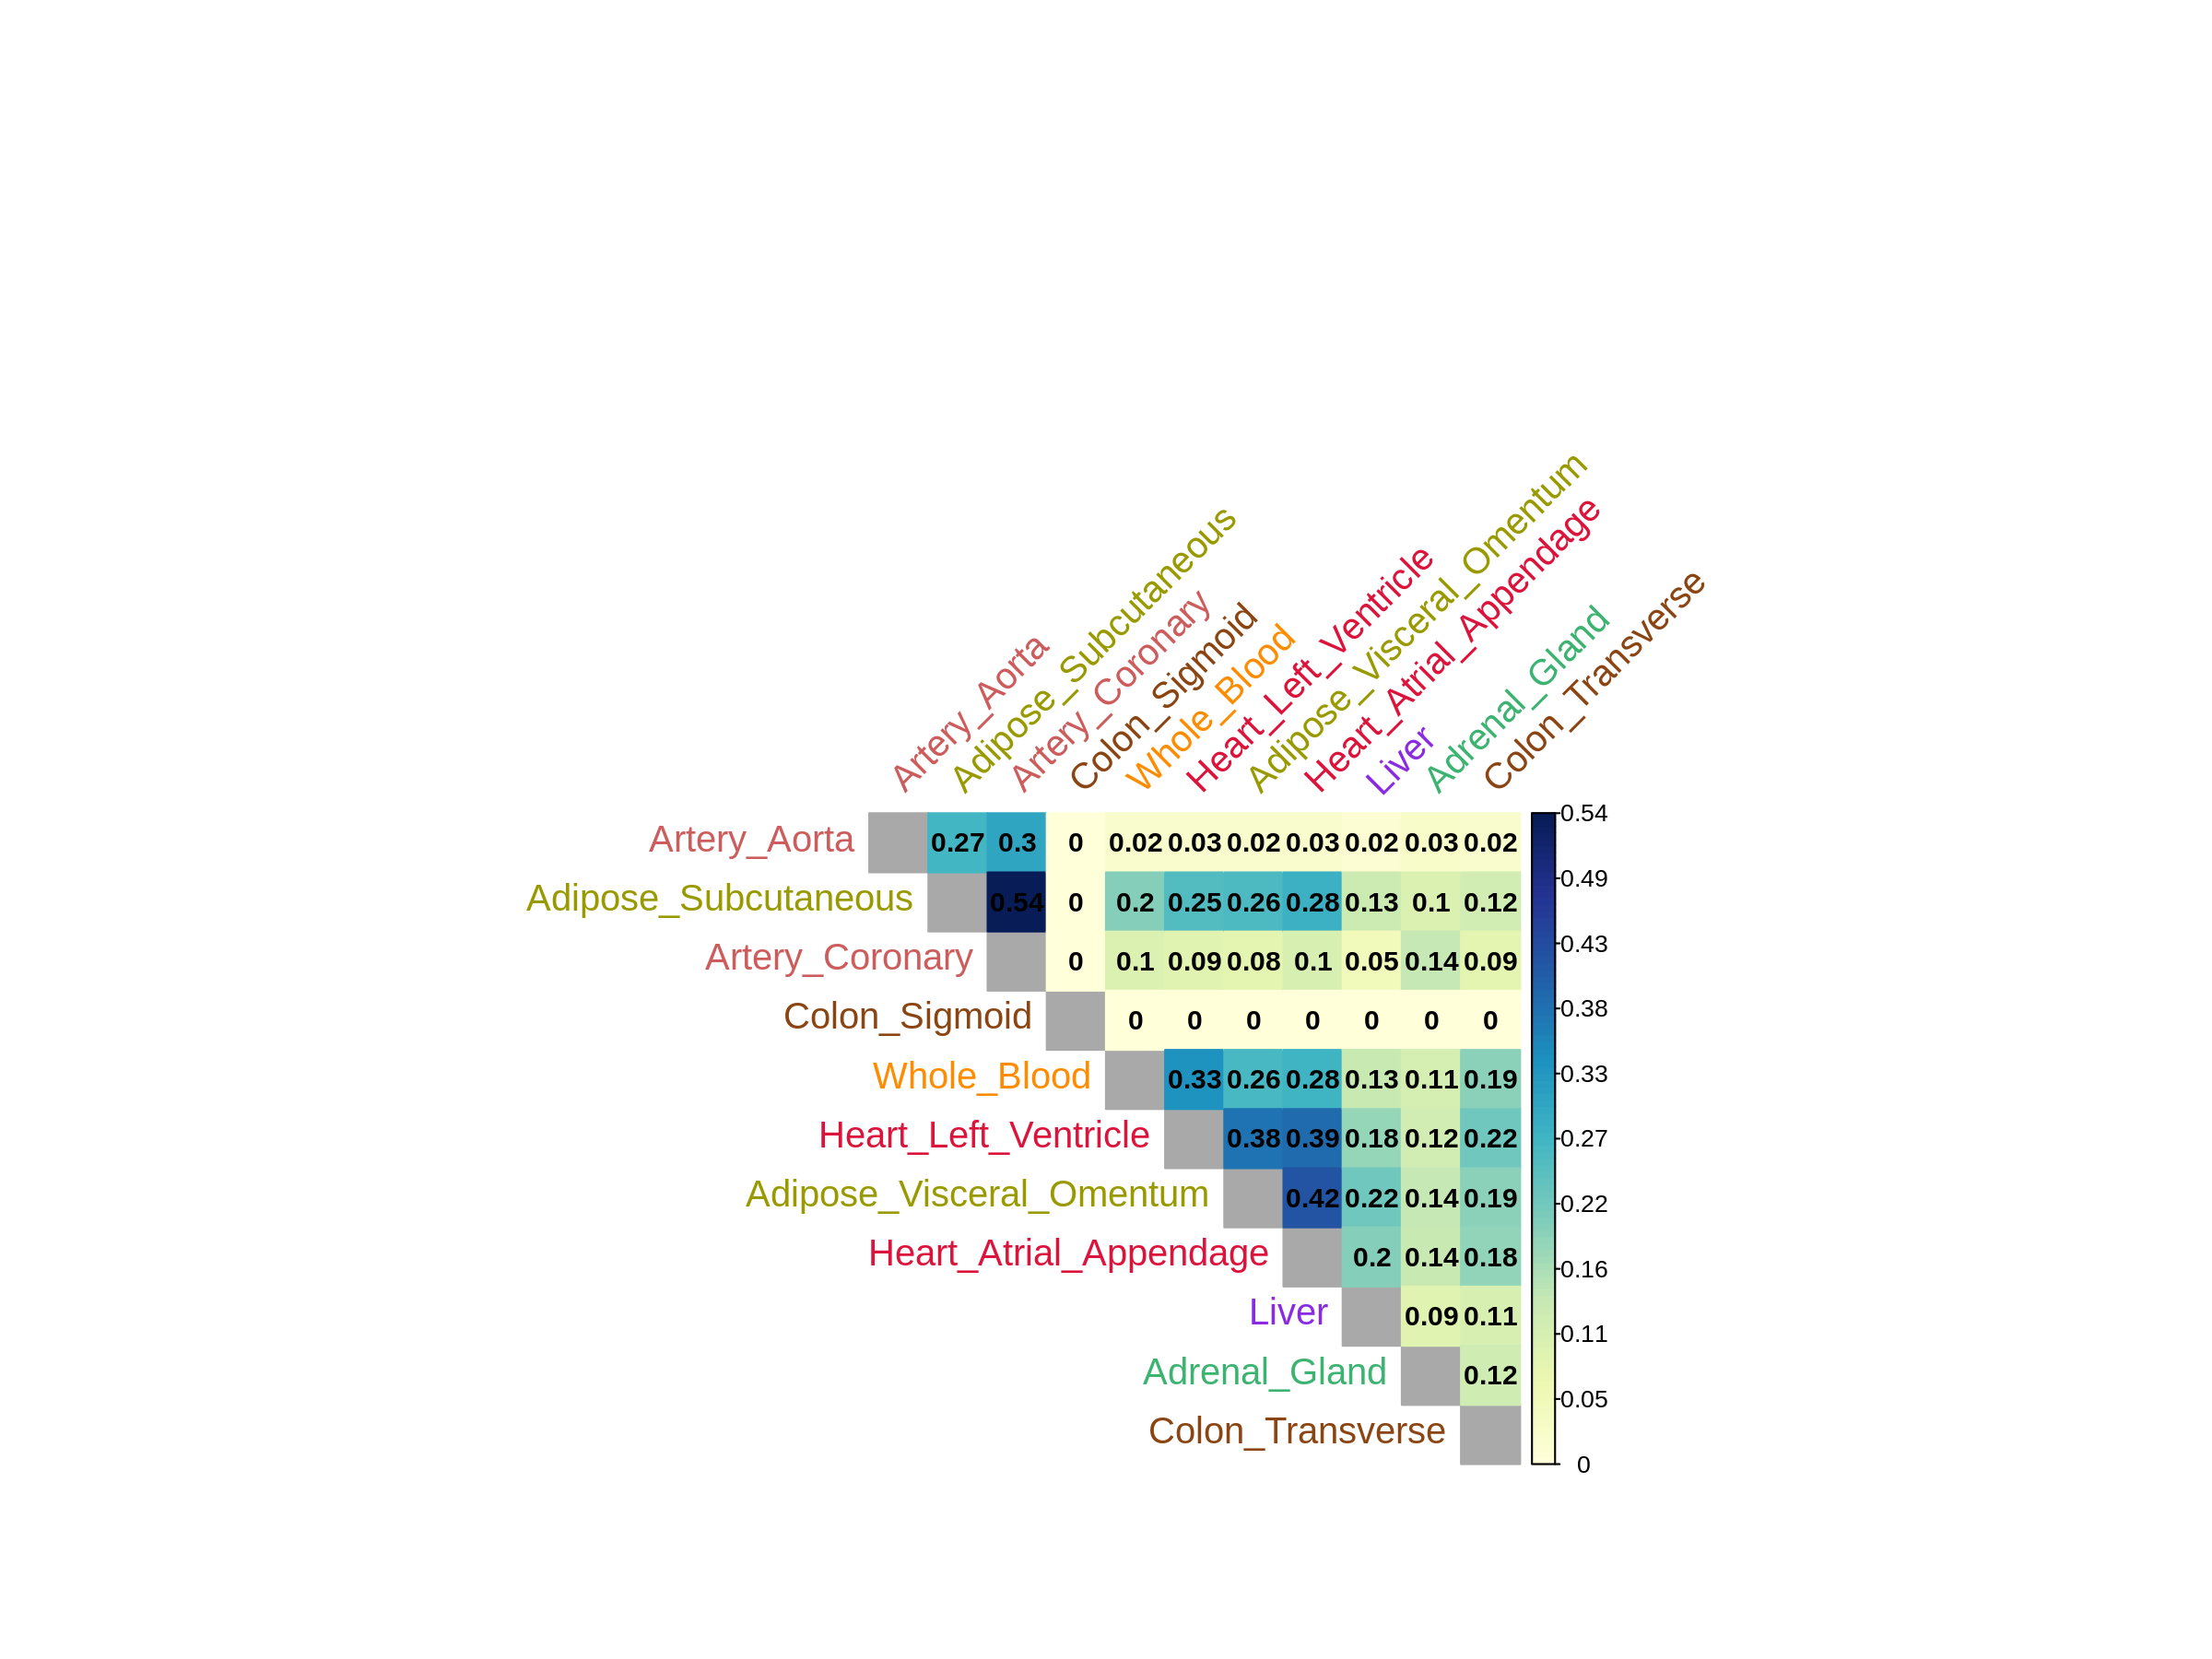

In [10]:
### plot NMI ###

options(repr.plot.width = 12, repr.plot.height = 9, repr.plot.res = 200)

# plot NMI
col <- colorRampPalette(brewer.pal(9, 'YlGnBu'))(100)
ord <- corrMatOrder(NMI_mat, order="hclust", hclust.method = 'ward.D')
newcolours <- color_tissues$color[match(tissues_name, color_tissues$tissues)][ord]
title_pl <- sprintf('NMI %s %s', type_data, type_input)

pdf(file = sprintf('%sNMI_%s_%s.pdf', outFold, type_data, type_input), width = 9, height = 6, compress = F, pointsize = 12)
corrplot(NMI_mat, type="upper", order = 'hclust', hclust.method = 'ward.D',
         tl.col = newcolours, tl.cex=1.2,
         col = c(col), method = 'color', tl.srt=45, cl.align.text='c',
         addCoef.col = "black",na.label = 'square', na.label.col = 'darkgrey', is.corr = F, number.cex=0.9, mar = c(0,0,1,0))
dev.off()

corrplot(NMI_mat, type="upper", order = 'hclust', hclust.method = 'ward.D',
         tl.col = newcolours, tl.cex=1.2,
         col = c(col), method = 'color', tl.srt=45, cl.align.text='c',
         addCoef.col = "black",na.label = 'square', na.label.col = 'darkgrey', is.corr = F, number.cex=0.9, mar = c(0,0,1,0))
  


In [16]:
max_gr <- max(as.numeric(sapply(unique(as.character(df_div$gr)), function(x) strsplit(x, 'gr')[[1]][2])))
df_div$gr <- factor(df_div$gr, levels = paste0('gr', 1:max_gr))
df_div$tissue <- factor(df_div$tissue, levels = tissues_name)
newcolours <- color_tissues$color[match(tissues_name, color_tissues$tissues)]
color_gr <- rev(pal_d3("category20")(length(levels(df_div$gr))))
color_gr 

[1] "#AEC7E8FF" "#17BECFFF" "#BCBD22FF" "#7F7F7FFF" "#E377C2FF" "#8C564BFF"
 [7] "#9467BDFF" "#D62728FF" "#2CA02CFF" "#FF7F0EFF" "#1F77B4FF"

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


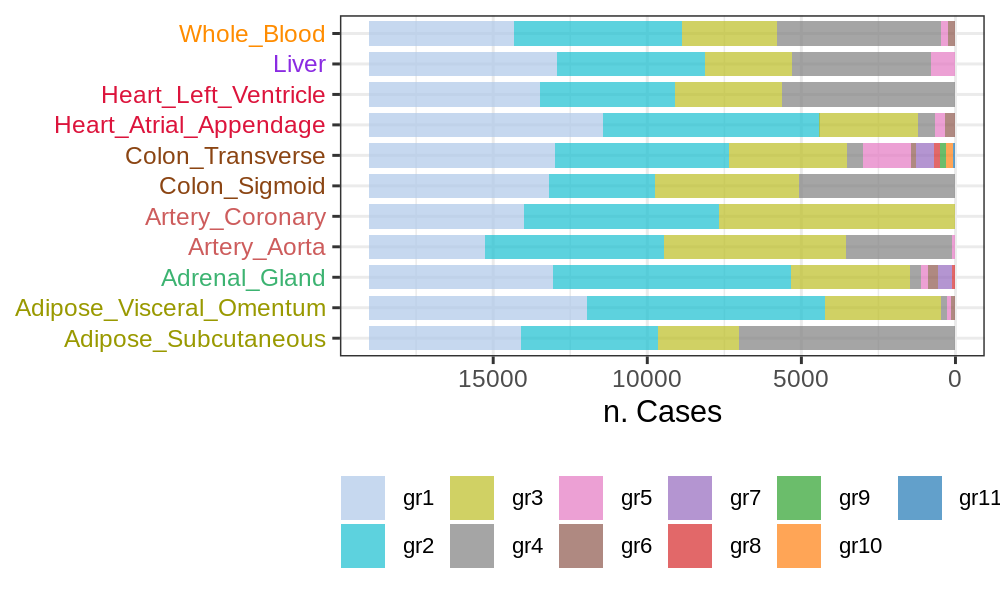

In [22]:
### plot clustering number distribution ###
options(repr.plot.width = 5, repr.plot.height = 3, repr.plot.res = 200)

max_gr <- max(as.numeric(sapply(unique(as.character(df_div$gr)), function(x) strsplit(x, 'gr')[[1]][2])))
df_div$gr <- factor(df_div$gr, levels = paste0('gr', 1:max_gr))
df_div$tissue <- factor(df_div$tissue, levels = tissues_name)
newcolours <- color_tissues$color[match(tissues_name, color_tissues$tissues)]
color_gr <- rev(pal_d3("category20")(length(levels(df_div$gr))))
df_cluster$tissue <- factor(df_cluster$tissue, levels = tissues_name)
  
pl <- ggplot(data = df_div, aes(x = tissue, y = n_samples, fill = gr))+
    geom_bar(alpha = 0.7, width = 0.8, stat = 'identity')+
    ylab('n. Cases')+ 
    theme_bw()+ 
    theme(legend.position = 'bottom', 
          legend.text = element_text(size = 8), legend.title = element_blank(), 
          axis.title.y = element_blank(), axis.text.y = element_text(colour = newcolours))+
    scale_fill_manual(values = color_gr)+
    coord_flip() + 
    scale_y_reverse() +
    guides(fill = guide_legend(nrow = 2))

ggsave(filename = sprintf('%scluster_nsamples_%s_%s.pdf', outFold, type_data, type_input), 
       plot = pl, width = 5, height = 3, 
       dpi = 500, compress = F)
pl





In [23]:
df_div[order(df_div$n_samples),]
df_cluster

,tissue,n_samples,gr
,<fct>,<int>,<fct>
41,Colon_Transverse,92,gr11
9,Adipose_Visceral_Omentum,112,gr5
18,Adrenal_Gland,113,gr8
23,Artery_Aorta,120,gr5
10,Adipose_Visceral_Omentum,150,gr6
36,Colon_Transverse,162,gr6
39,Colon_Transverse,187,gr9
38,Colon_Transverse,206,gr8
8,Adipose_Visceral_Omentum,207,gr4


tissue,n_cluster,modularity,coverage_and_conductance
<fct>,<dbl>,<dbl>,<dbl>
Adipose_Subcutaneous,4,0.2878240,1.1637246
Adipose_Visceral_Omentum,6,0.2463524,1.2015801
Adrenal_Gland,8,0.1833179,0.9674864
Artery_Aorta,5,0.2463218,1.0321655
Artery_Coronary,3,0.2957373,1.3024778
Colon_Sigmoid,4,0.3387370,1.2193545
Colon_Transverse,11,0.1745776,0.8196475
Heart_Atrial_Appendage,6,0.2432539,1.1461499
Heart_Left_Ventricle,4,0.2478222,1.0369386
